```
This software is part of GPU Ocean. 

Copyright (C) 2017, 2018 SINTEF Digital
Copyright (C) 2017, 2018 Norwegian Meteorological Institute

This notebook implements the lake-at-rest steady-state test case, as 
reported under Case A in Test Cases for Rotational Shallow-Water Schemes
by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

#  Case A, part 1: Lake at rest

Checking that all simulators are able to preserve lake at rest given smooth non-constant bottom topography.

#### Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


import os
import datetime
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))


#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
gpu_ctx = Common.CUDAContext()

## Setting simulation parameters

In [3]:
"""
Generates a smooth bottom topography
"""
def make2DBottomTopography(h, H0, nx, ny, dx, dy, halo):
    for j in range(0, ny+halo[0]+halo[2]):
        y = (j-halo[2])/(4*np.pi)
        for i in range(0, nx+halo[1]+halo[3]):
            x = (i-halo[3])/(4*np.pi)
            h[j,i] = H0 + 0.2*(np.cos(y) + np.sin(x))



In [4]:
# Simulation parameters:

nx = 200
ny = 200
dx = 1.0
dy = 1.0

dt = 0.1
T1 = 10.0
T2 = 100.0
T3 = 1000.0

# Other paramters:
g = 9.81
f = 0.2
r = 0.0
A = 0.0

H0 = 1.0


# Running and evaluating simulations

-------------- KP07 -------------- 
T1 = 10.0
-- at time 10.000000149011612 --
Max/min eta:  7.332304e-08 -7.194566e-08
Max/min hu :  3.8296025e-07 -4.9993406e-07
Max/min hv :  3.9115548e-07 -4.69014e-07
T2 = 100.0
-- at time 110.00000163912773 --
Max/min eta:  7.545014e-08 -7.243659e-08
Max/min hu :  6.154188e-07 -4.8242526e-07
Max/min hv :  4.6044588e-07 -4.8819953e-07
T3 = 1000.0
-- at time 1110.000016540289 --
Max/min eta:  7.757777e-08 -7.369009e-08
Max/min hu :  6.027513e-07 -4.656671e-07
Max/min hv :  4.7925687e-07 -5.166962e-07
-------------- CDKLM -------------- 
T1 = 10.0
-- at time 100.00000149011612 --
Max/min eta:  1.3005008e-07 -1.7836308e-07
Max/min hu :  2.2798804e-06 -2.4744293e-06
Max/min hv :  2.4441624e-06 -2.7220658e-06
T2 = 100.0
-- at time 200.00000298023224 --
Max/min eta:  1.5044589e-07 -1.6539462e-07
Max/min hu :  2.471354e-06 -2.486626e-06
Max/min hv :  2.6755083e-06 -2.7745966e-06
T3 = 1000.0
-- at time 1200.0000178813934 --
Max/min eta:  1.433577e-07 -1.533

/home/havahol/playground/gpu-ocean/local-havahol-gpu-ocean/gpu_ocean/SWESimulators/CTCS.py:134: UserWarning: The CUDA compiler succeeded, but said the following:
/home/havahol/playground/gpu-ocean/local-havahol-gpu-ocean/gpu_ocean/SWESimulators/gpu_kernels/CTCS_step_kernel.cu(237): warning: variable "h_x" was declared but never referenced

/home/havahol/playground/gpu-ocean/local-havahol-gpu-ocean/gpu_ocean/SWESimulators/gpu_kernels/CTCS_step_kernel.cu(342): warning: variable "h_y" was declared but never referenced


  jit_compile_args={


-------------- CTCS -------------- 
T1 = 10.0
-- at time 10.000000230967999 --
Max/min eta:  0.0 0.0
Max/min hu :  -0.0 -0.0
Max/min hv :  -0.0 -0.0
T2 = 100.0
-- at time 109.99999736249447 --
Max/min eta:  0.0 0.0
Max/min hu :  -0.0 -0.0
Max/min hv :  -0.0 -0.0
-------------- FBL -------------- 
T1 = 10.0
-- at time 10.000000149011612 --
Max/min eta:  0.0 0.0
Max/min hu :  0.0 0.0
Max/min hv :  -0.0 -0.0
T2 = 100.0
-- at time 110.00000163912773 --
Max/min eta:  0.0 0.0
Max/min hu :  0.0 0.0
Max/min hv :  -0.0 -0.0


Text(0.5, 1.0, 'FBL $\\eta$, t = 110.00000163912773')

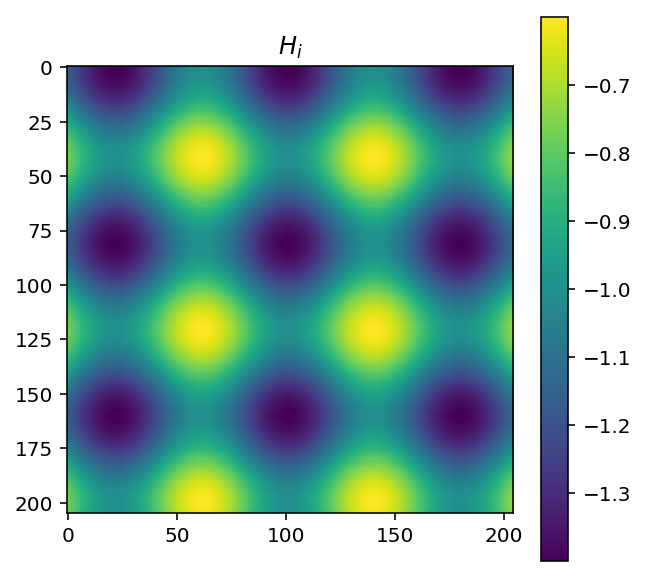

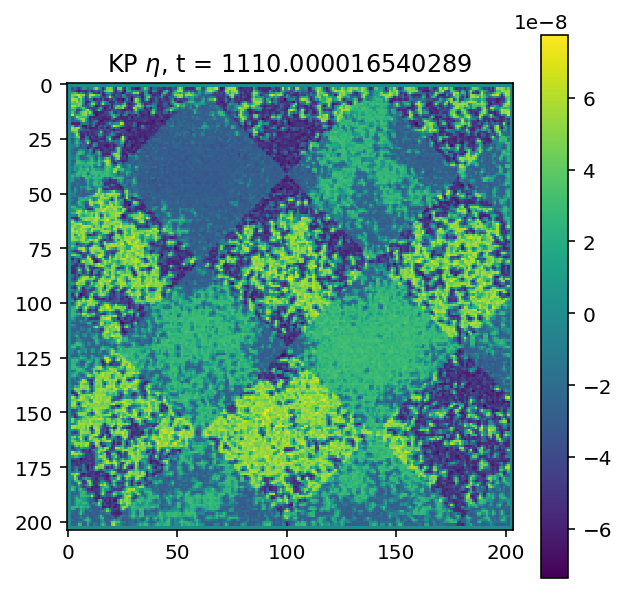

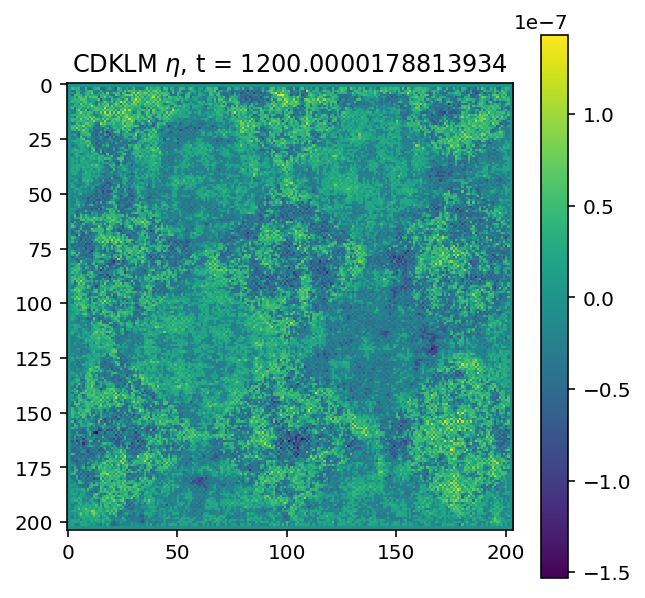

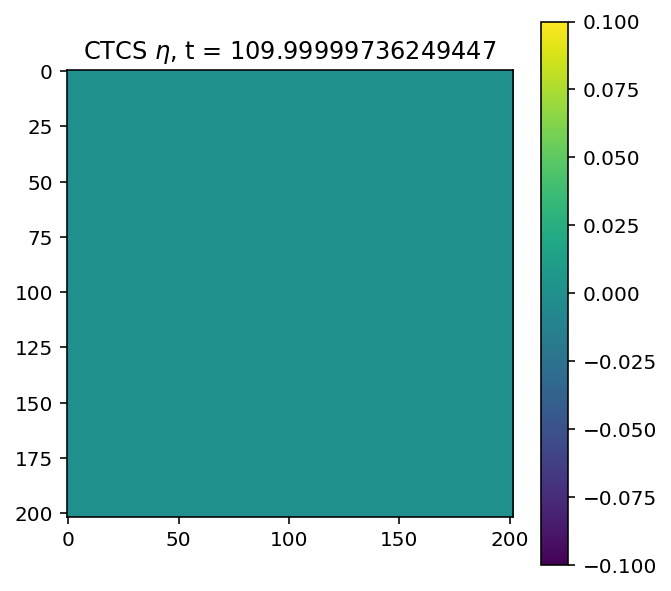

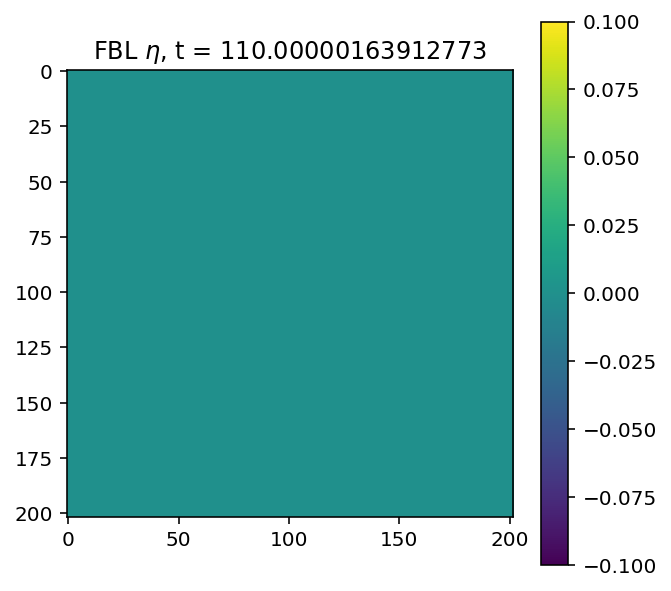

In [5]:
def printStats(eta, hu, hv, t):
    print("-- at time " + str(t) + " --")
    print("Max/min eta: ", np.max(eta), np.min(eta))
    print("Max/min hu : ", np.max(hu),  np.min(hu))
    print("Max/min hv : ", np.max(hv),  np.min(hv))



## Non-staggered:
boundaryConditions = Common.BoundaryConditions()
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
make2DBottomTopography(Hi, H0, nx+1, ny+1, dx, dy, ghosts)

fig = plt.figure(figsize=(5,5))
plt.imshow(-Hi)
plt.colorbar()
plt.title("$H_i$")


# KP07
sim = KP07.KP07(gpu_ctx, \
                eta0, Hi, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, \
                boundary_conditions=boundaryConditions)

print("-------------- KP07 -------------- ")
print("T1 = " + str(T1))
t_kp07 = sim.step(T1)
eta_kp07, hu_kp07, hv_kp07 = sim.download()
printStats(eta_kp07, hu_kp07, hv_kp07, t_kp07)
print("T2 = " + str(T2))
t_kp07 = sim.step(T2)
eta_kp07, hu_kp07, hv_kp07 = sim.download()
printStats(eta_kp07, hu_kp07, hv_kp07, t_kp07)
print("T3 = " + str(T3))
t_kp07 = sim.step(T3)
eta_kp07, hu_kp07, hv_kp07 = sim.download()
printStats(eta_kp07, hu_kp07, hv_kp07, t_kp07)

fig = plt.figure(figsize=(5,5))
plt.imshow(eta_kp07)
plt.colorbar()
plt.title("KP $\eta$, t = " + str(t_kp07))


# CDKLM16
sim = CDKLM16.CDKLM16(gpu_ctx, \
                      eta0, u0, v0, Hi, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r, \
                      boundary_conditions=boundaryConditions)
print("-------------- CDKLM -------------- ")
print("T1 = " + str(T1))
t_cdklm = sim.step(T2)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()
printStats(eta_cdklm, hu_cdklm, hv_cdklm, t_cdklm)
print("T2 = " + str(T2))
t_cdklm = sim.step(T2)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()
printStats(eta_cdklm, hu_cdklm, hv_cdklm, t_cdklm)
print("T3 = " + str(T3))
t_cdklm = sim.step(T3)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()
printStats(eta_cdklm, hu_cdklm, hv_cdklm, t_cdklm)

fig = plt.figure(figsize=(5,5))
plt.imshow(eta_cdklm)
plt.colorbar()
plt.title("CDKLM $\eta$, t = " + str(t_cdklm))


## Staggered CTCS
ghosts = [1,1,1,1] # north, east, south, west
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
h0 = np.ones(dataShape, dtype=np.float32, order='C') 
eta0_ctcs = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');    
make2DBottomTopography(h0, H0, nx, ny, dx, dy, ghosts)

ctcs_sim = CTCS.CTCS(gpu_ctx, \
                     h0, eta0_ctcs, u0, v0, \
                     nx, ny, dx, dy, dt, \
                     g, f, r, A, \
                     boundary_conditions=boundaryConditions )

print("-------------- CTCS -------------- ")
print("T1 = " + str(T1))
t_ctcs = ctcs_sim.step(T1)
eta_ctcs, hu_ctcs, hv_ctcs = ctcs_sim.download()
printStats(eta_ctcs, hu_ctcs, hv_ctcs, t_ctcs)
print("T2 = " + str(T2))
t_ctcs = ctcs_sim.step(T2)
eta_ctcs, hu_ctcs, hv_ctcs = ctcs_sim.download()
printStats(eta_ctcs, hu_ctcs, hv_ctcs , t_ctcs)


fig = plt.figure(figsize=(5,5))
plt.imshow(eta_ctcs)
plt.colorbar()
plt.title("CTCS $\eta$, t = " + str(t_ctcs))

## Staggered FBL
ghosts = [0,0,0,0]
#validDomain = [None, None, 0, 0]    
boundaryConditions = Common.BoundaryConditions()
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

h0 = np.ones(dataShape, dtype=np.float32, order='C')
eta0_fbl = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');
make2DBottomTopography(h0, H0, nx, ny, dx, dy, ghosts)

fbl_sim = FBL.FBL(gpu_ctx, \
                  h0, eta0_fbl, u0, v0, \
                  nx, ny, \
                  dx, dy, dt, \
                  g, f, r, \
                  boundary_conditions=boundaryConditions)
#t = ctcs_sim.step(dt*370)
print("-------------- FBL -------------- ")
print("T1 = " + str(T1))
t_fbl = fbl_sim.step(T1)
eta_fbl, hu_fbl, hv_fbl = fbl_sim.download()
printStats(eta_fbl, hu_fbl, hv_fbl, t_fbl)
print("T2 = " + str(T2))
t_fbl = fbl_sim.step(T2)
eta_fbl, hu_fbl, hv_fbl = fbl_sim.download()
printStats(eta_fbl, hu_fbl, hv_fbl, t_fbl)


fig = plt.figure(figsize=(5,5))
plt.imshow(eta_fbl)
plt.colorbar()
plt.title("FBL $\eta$, t = " + str(t_fbl))